# Sparkify Project Workspace
This workspace contains a tiny subset (128MB) of the full dataset available (12GB). Feel free to use this workspace to build your project, or to explore a smaller subset with Spark before deploying your cluster on the cloud. Instructions for setting up your Spark cluster is included in the last lesson of the Extracurricular Spark Course content.

You can follow the steps below to guide your data analysis and model building portion of this project.

In [1]:
# import libraries
from pyspark.sql import SparkSession, Window
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.sql.functions import udf,count,when,isnan,col,avg,stddev,max,min
from pyspark.sql.types import IntegerType,StringType,DoubleType
from pyspark.ml.feature import MinMaxScaler,VectorAssembler
from pyspark.ml import Pipeline

from pyspark.sql import functions as F
from user_agents import parse # pip install pyyaml ua-parser user-agents
from functools import reduce
import calendar

from sklearn import preprocessing
import pandas as pd

import re
import time

%matplotlib inline

In [2]:
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.classification import GBTClassifier
from pyspark.ml.classification import LinearSVC
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from statsmodels.stats.proportion import proportions_ztest

In [3]:
# create a Spark session
spark = SparkSession \
        .builder \
        .master("local[*]") \
        .config("spark.ui.port",3000) \
        .appName("Sparkify") \
        .getOrCreate()

# Load and Clean Dataset
In this workspace, the mini-dataset file is `mini_sparkify_event_data.json`. Load and clean the dataset, checking for invalid or missing data - for example, records without userids or sessionids. 

### Load data

In [4]:
df = spark.read.json('mini_sparkify_event_data.json')

In [5]:
df.limit(5).toPandas()

,artist,auth,firstName,gender,itemInSession,lastName,length,level,location,method,page,registration,sessionId,song,status,ts,userAgent,userId
0,Martha Tilston,Logged In,Colin,M,50,Freeman,277.89016,paid,"Bakersfield, CA",PUT,NextSong,1538173362000,29,Rockpools,200,1538352117000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30
1,Five Iron Frenzy,Logged In,Micah,M,79,Long,236.09424,free,"Boston-Cambridge-Newton, MA-NH",PUT,NextSong,1538331630000,8,Canada,200,1538352180000,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",9
2,Adam Lambert,Logged In,Colin,M,51,Freeman,282.82730,paid,"Bakersfield, CA",PUT,NextSong,1538173362000,29,Time For Miracles,200,1538352394000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30
3,Enigma,Logged In,Micah,M,80,Long,262.71302,free,"Boston-Cambridge-Newton, MA-NH",PUT,NextSong,1538331630000,8,Knocking On Forbidden Doors,200,1538352416000,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",9
4,Daft Punk,Logged In,Colin,M,52,Freeman,223.60771,paid,"Bakersfield, CA",PUT,NextSong,1538173362000,29,Harder Better Faster Stronger,200,1538352676000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30


In [6]:
df.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



In [7]:
df.describe().toPandas()

,summary,artist,auth,firstName,gender,itemInSession,lastName,length,level,location,method,page,registration,sessionId,song,status,ts,userAgent,userId
0,count,228108,286500,278154,278154,286500,278154,228108,286500,278154,286500,286500,278154,286500,228108,286500,286500,278154,286500
1,mean,551.0852017937219,None,None,None,114.41421291448516,None,249.1171819778458,None,None,None,None,1.5353588340844272E12,1041.526554973822,Infinity,210.05459685863875,1.5409568898104834E12,None,59682.02278593872
2,stddev,1217.7693079161374,None,None,None,129.76726201140994,None,99.23517921058361,None,None,None,None,3.291321616327586E9,726.7762634630741,NaN,31.50507848842214,1.5075439608226302E9,None,109091.9499991047
3,min,!!!,Cancelled,Adelaida,F,0,Adams,0.78322,free,"Albany, OR",GET,About,1521380675000,1,ÃÂg ÃÂtti GrÃÂ¡a ÃÂsku,200,1538352117000,"""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_10)...",
4,max,ÃÂlafur Arnalds,Logged Out,Zyonna,M,1321,Wright,3024.66567,paid,"Winston-Salem, NC",PUT,Upgrade,1543247354000,2474,ÃÂau hafa sloppiÃÂ° undan ÃÂ¾unga myrkursins,404,1543799476000,Mozilla/5.0 (compatible; MSIE 9.0; Windows NT ...,99


### Clean data

In [8]:
#review NaN or Null data by column
df.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df.columns]).toPandas()

,artist,auth,firstName,gender,itemInSession,lastName,length,level,location,method,page,registration,sessionId,song,status,ts,userAgent,userId
0,58392,0,8346,8346,0,8346,58392,0,8346,0,0,8346,0,58392,0,0,8346,0


In [9]:
# Review UserId and sessionId missing values 
print(f"Number of userId with empty string:{df.filter(df['userId']=='').count()}")
print(f"Number of sessionId with empty string:{df.filter(df['sessionId']=='').count()}")

Number of userId with empty string:8346
Number of sessionId with empty string:0


In [10]:
#Clean Data:
#anonymize data, remove first name and last name
columns_to_drop = ['firstName','lastName']
df = df.drop(*columns_to_drop)

#remove userIds with empty values
df = df.filter(df['userId']!='') 

In [11]:
#review NaN or Null data by column after Clean Data
df.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df.columns]).toPandas()

,artist,auth,gender,itemInSession,length,level,location,method,page,registration,sessionId,song,status,ts,userAgent,userId
0,50046,0,0,0,50046,0,0,0,0,0,0,50046,0,0,0,0


In [12]:
print(f"Number of userId with empty string:{df.filter(df['userId']=='').count()}")
print(f"Number of sessionId with empty string:{df.filter(df['sessionId']=='').count()}")

Number of userId with empty string:0
Number of sessionId with empty string:0


# Exploratory Data Analysis
When you're working with the full dataset, perform EDA by loading a small subset of the data and doing basic manipulations within Spark. In this workspace, you are already provided a small subset of data you can explore.

In [13]:
df.createOrReplaceTempView("Sparkify_view")

In [14]:
gender_distribution = spark.sql("""
    SELECT gender, COUNT(DISTINCT userId) user_count
        FROM Sparkify_view
    GROUP BY gender
    ORDER BY user_count DESC
""").toPandas()
gender_distribution

,gender,user_count
0,M,121
1,F,104


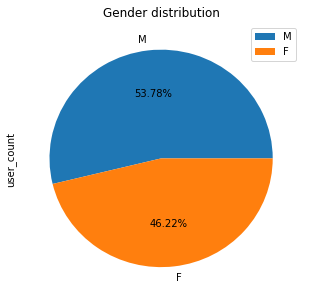

In [15]:
gender_distribution.plot.pie(rot=0,title = 'Gender distribution',
                             x='gender', 
                             y = 'user_count' ,
                             labels =['M','F'],
                             figsize=(5,5),
                             autopct="%.2f%%")

#### There are 225 users, 53.78 of all of them are males and 46.22 are females

In [16]:
user_df=  spark.sql("""
    SELECT level, CONCAT(auth,' - ',gender) as auth_and_gender, COUNT(DISTINCT userId) user_count
        FROM Sparkify_view
    GROUP BY level, CONCAT(auth,' - ',gender)
    ORDER BY user_count DESC
""").toPandas()
user_df

,level,auth_and_gender,user_count
0,free,Logged In - M,106
1,free,Logged In - F,89
2,paid,Logged In - M,86
3,paid,Logged In - F,79
4,paid,Cancelled - M,18
5,free,Cancelled - M,14
6,paid,Cancelled - F,13
7,free,Cancelled - F,7


There are 225 different users

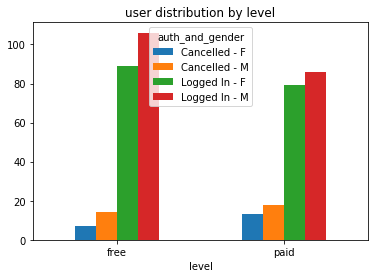

In [17]:
ax = (user_df.pivot(index='level', columns='auth_and_gender', values='user_count')
      .plot.bar(rot=0,title = 'user distribution by level'))

#### - Most of the users are in the `free` level, we have more Male users.

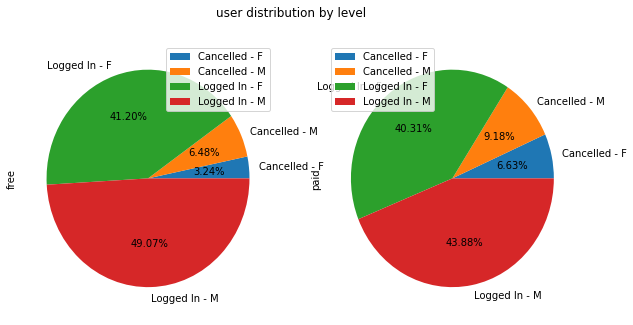

In [18]:
ax = (user_df.pivot(index='auth_and_gender', columns='level', values='user_count')
      .plot.pie(rot=0,title = 'user distribution by level',subplots=True, figsize=(10,5), autopct="%.2f%%"))
#ax = churn_distribution.groupby(['level','status'], as_index=False).sum().pivot(index='status', columns='level', values='user_count').plot.pie(rot=0,title = 'Churn distribution by level',subplots=True,autopct='%1.0f%%')

#### In percentage, the `paid` level has more churn probability. the male users that paid the service has more probability of churn

In [19]:
length_data = spark.sql(
    """
    SELECT length
        FROM Sparkify_view
""")

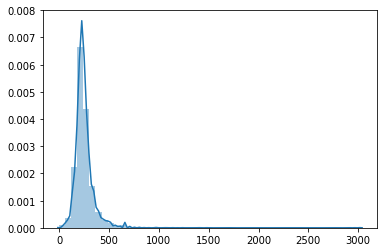

In [20]:
sns.distplot(length_data.toPandas().dropna());

#### The mean length is 249.11 and has a Standard deviation 129.76; as you can see, most of the data is between 0 an 500

In [21]:
#get users by Location
location_count = spark.sql('''
        SELECT location,COUNT(DISTINCT userId) AS user_count
        FROM Sparkify_view
        GROUP BY location
        ORDER BY user_count DESC
''').toPandas()
location_count = location_count.join(location_count['location'].str.split(',',expand=True)
                                     .rename(columns={0:'city',1:'state'})).drop('location',axis=1)

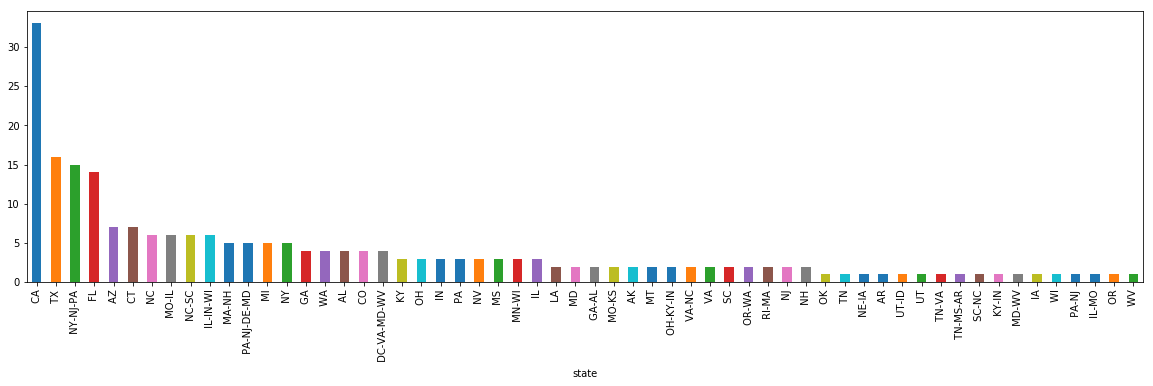

In [22]:
location_count.groupby('state')['user_count'].sum().sort_values(ascending=False).plot(kind='bar',figsize=(20,5));

#### California and Texas are the places where there are more users

In [23]:
page_count = spark.sql("""
    SELECT page, COUNT(*) page_count
        FROM Sparkify_view
    GROUP BY auth,page
    ORDER BY page_count DESC
""").toPandas()
page_count

,page,page_count
0,NextSong,228108
1,Thumbs Up,12551
2,Home,10082
3,Add to Playlist,6526
4,Add Friend,4277
5,Roll Advert,3933
6,Logout,3226
7,Thumbs Down,2546
8,Downgrade,2055
9,Settings,1514


In [24]:
# session information 
session_count = spark.sql("""
    SELECT UserId, 
        SessionId, 
        COUNT(song) songs_count,
        cast((max(ts) - min(ts))/3600000.0 as Integer) session_duration_hours
        FROM Sparkify_view
    GROUP BY UserId,SessionId
""").toPandas()

In [25]:
session_count.describe()

,SessionId,songs_count,session_duration_hours
count,3176.000000,3176.000000,3176.000000
mean,922.456549,71.822418,4.528967
std,731.087045,92.773258,6.478586
min,1.000000,0.000000,0.000000
25%,264.000000,14.000000,0.000000
50%,734.500000,39.000000,2.000000
75%,1552.250000,90.250000,6.000000
max,2474.000000,1093.000000,74.000000


#### By mean each person lissen by session 72 songs and it will be like 4 hours and 30 minutes

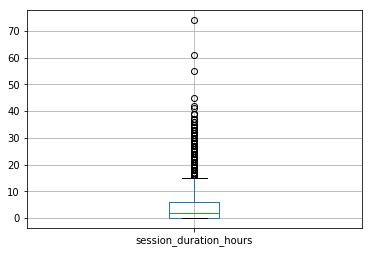

In [26]:
boxplot = session_count.boxplot(column=['session_duration_hours'])

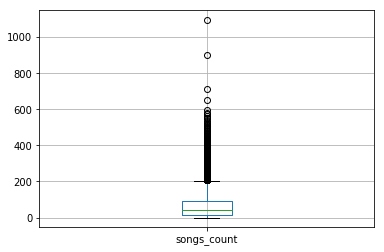

In [27]:
boxplot = session_count.boxplot(column=['songs_count'])

In [28]:
# describe status by Session
status_count = df.groupBy(['UserId','SessionId']).pivot('status').count().na.fill(0)
status_count.describe().toPandas()

,summary,UserId,SessionId,200,307,404
0,count,3176,3176,3176,3176,3176
1,mean,70837.98016372796,922.4565491183879,80.20088161209068,7.299748110831234,0.07934508816120907
2,stddev,113372.61681292772,731.0870448091692,101.1097350975957,9.04878535892884,0.30118142061014996
3,min,10,1,1,0,0
4,max,99,2474,1183,99,3


In [29]:
hour_data =  spark.sql("""
    SELECT  
        dayOfWeek(from_unixtime( ts/1000.00)) dayofweek,
        hour(from_unixtime( ts/1000.00)) hour,
        count(*) count
    FROM Sparkify_view
    group by 
        dayOfWeek(from_unixtime( ts/1000.00)) ,
        dayofmonth(from_unixtime( ts/1000.00)) ,
        hour(from_unixtime( ts/1000.00)) 
        
    
""").toPandas()

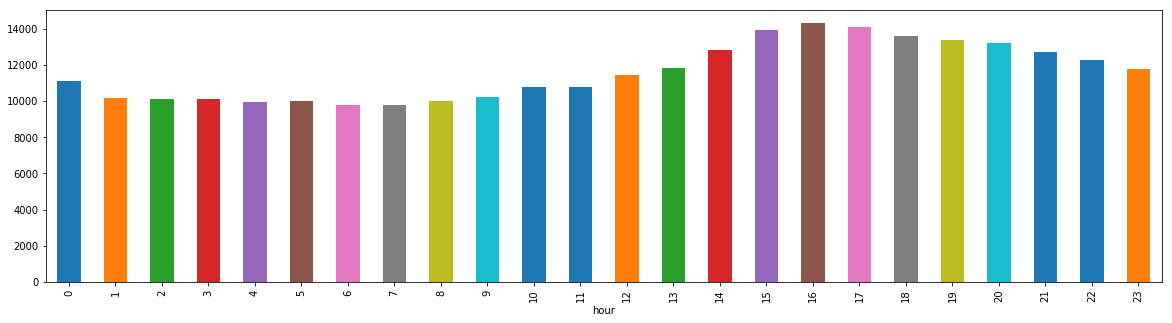

In [30]:
hour_data.groupby('hour')['count'].sum().plot(kind='bar',figsize=(20,5));

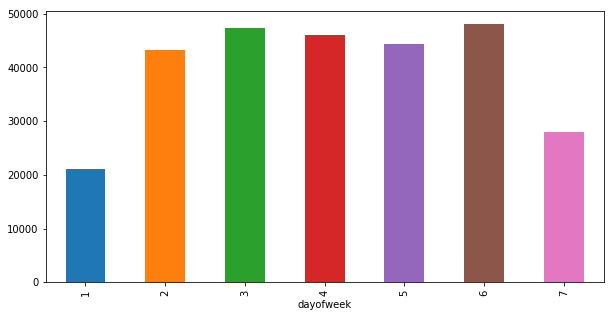

In [31]:
hour_data.groupby('dayofweek')['count'].sum().plot(kind='bar',figsize=(10,5));

In [32]:
#User Agent
udf_os_family = udf(lambda x: parse(x).os.family, StringType())
udf_device_family = udf(lambda x: parse(x).device.family, StringType())
udf_browser_family = udf(lambda x: parse(x).browser.family, StringType())

df_os_family = (df
                .withColumn('OS_family',udf_os_family(df.userAgent))
                .withColumn('device_family',udf_device_family(df.userAgent))
                .withColumn('browser_family',udf_browser_family(df.userAgent))
               )
#each user is connection only by a common userAgent
df_pivot_device = df_os_family.groupBy("userId").pivot("device_family").agg(F.lit(1)).na.fill(0).toPandas().drop(columns=['userId'])
df_pivot_browser = df_os_family.groupBy("userId").pivot("browser_family").agg(F.lit(1)).na.fill(0).toPandas().drop(columns=['userId'])
df_pivot_OS = df_os_family.groupBy("userId").pivot("OS_family").agg(F.lit(1)).na.fill(0).toPandas().drop(columns=['userId'])

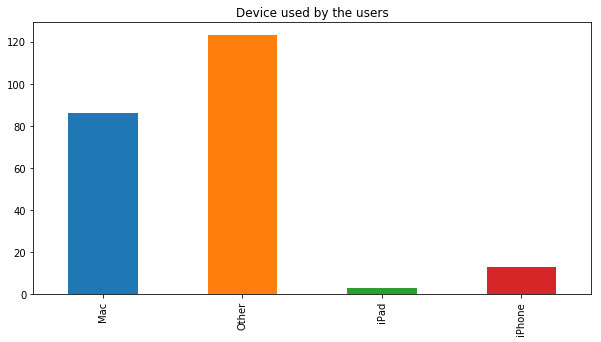

In [33]:
df_pivot_device.sum().plot(kind='bar',figsize=(10,5), title='Device used by the users')

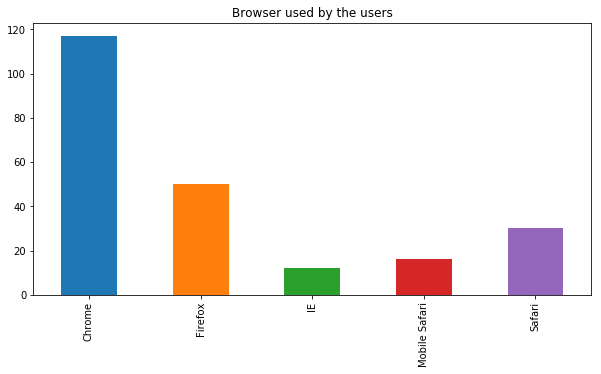

In [34]:
df_pivot_browser.sum().plot(kind='bar',figsize=(10,5), title='Browser used by the users')

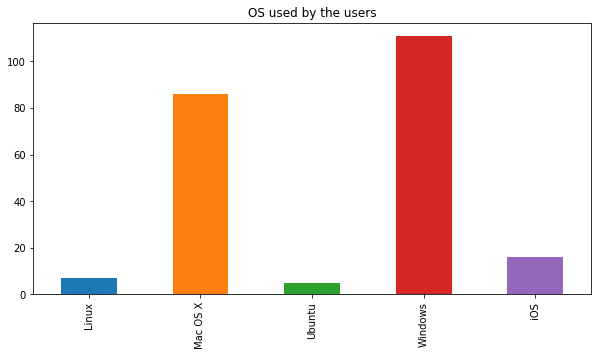

In [35]:
df_pivot_OS.sum().plot(kind='bar',figsize=(10,5), title='OS used by the users')

### Define Churn

Once you've done some preliminary analysis, create a column `Churn` to use as the label for your model. I suggest using the `Cancellation Confirmation` events to define your churn, which happen for both paid and free users. As a bonus task, you can also look into the `Downgrade` events.



In [36]:
df.select("page").distinct().toPandas()

,page
0,Cancel
1,Submit Downgrade
2,Thumbs Down
3,Home
4,Downgrade
5,Roll Advert
6,Logout
7,Save Settings
8,Cancellation Confirmation
9,About


In [37]:
df_churn_definition = spark.sql("""
    SELECT userId, 
           1 Churn
    FROM Sparkify_view
    WHERE  page = 'Cancellation Confirmation'
    GROUP BY userId
""")

In [38]:
#define Churn for each event on the users that have been access to the page `Cancellation Confirmation`
df_churn = df.join(df_churn_definition, on=['userId'], how='left').fillna(0, subset=['Churn'])

### Explore Data
Once you've defined churn, perform some exploratory data analysis to observe the behavior for users who stayed vs users who churned. You can start by exploring aggregates on these two groups of users, observing how much of a specific action they experienced per a certain time unit or number of songs played.

In [39]:
df_churn.createOrReplaceTempView("Sparkify_churn_view")

In [40]:
def validate_two_sided_hypotesis (fieldname, successes, samples, significance = 0.025):
    """
    validate if there is statistical difference based on significance (p value) for two populations. 
    The null hypotesis is that the proportions from the two populations are the same
    
    :param fieldname: string - field name that is evaluated
    :param successes: list of integer - number of elements that are classified as success
    :param samples: list of integer - number of total elements to evaluate
    :param significance: threshold to evaluate the p_value
    :return: no return
    """
    stat, p_value = proportions_ztest(successes,samples,alternative='two-sided')
    print('z_stat: %0.3f, p_value: %0.3f' % (stat, p_value))
    if p_value > significance:
       print (f"Fail to reject the null hypothesis - proportions from the two populations based on '{fieldname}' are the same ")
    else:
       print (f"Reject the null hypothesis - proportions from the two populations based on '{fieldname}' are different")

In [41]:
def scale_data_by_Churn(df, column_name, column_to_count = 'user_count'):
    """
    group data by Churn and scale each column
    
    :param df: pandas dataframe - dataframe to work on 
    :param column_name: string - column name of the dataframe to generate a group with `Churn`
    :param column_to_count: string - column name to perform the scale function
    :return: pandas dataframe - dataframe with the data scaled
    """
    
    df_data_group = (df
                     .groupby(['Churn',column_name], as_index=False)[column_to_count]
                     .sum()
                     .pivot(index=column_name, columns='Churn', values=column_to_count).fillna(0))
    normalized_df= (df_data_group-df_data_group.min())/(df_data_group.max()-df_data_group.min())
    return normalized_df

#### Gender

In [42]:
user_df=  spark.sql("""
    SELECT Churn, gender as gender, COUNT(DISTINCT userId) user_count
        FROM Sparkify_churn_view
    GROUP BY Churn, gender
    ORDER BY user_count DESC
""").toPandas()
user_df

,Churn,gender,user_count
0,0,M,89
1,0,F,84
2,1,M,32
3,1,F,20


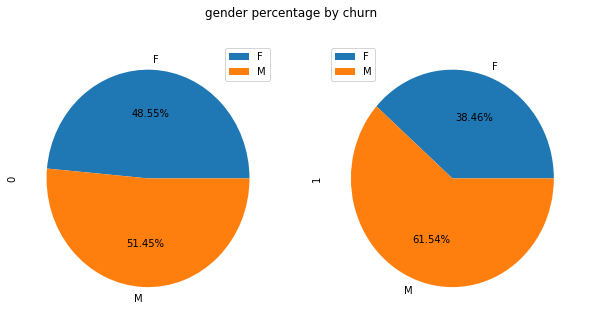

In [43]:
ax = (user_df.pivot(index='gender', columns='Churn', values='user_count')
      .plot.pie(rot=0,title = 'gender percentage by churn',subplots=True, figsize=(10,5), autopct="%.2f%%"))

In [44]:
validate_two_sided_hypotesis ('gender',[32,20],[131,104])

z_stat: 0.953, p_value: 0.340
Fail to reject the null hypothesis - proportions from the two populations based on 'gender' are the same 


#### length

In [45]:
df_churn.select(["Churn", "length"]).groupby(["Churn"]).agg(avg('length').alias('mean_length'),
                                                            stddev('length').alias('stdev_length'),
                                                            max('length').alias('max_length'),
                                                            min('length').alias('min_length')).toPandas()

,Churn,mean_length,stdev_length,max_length,min_length
0,1,248.632796,102.384977,3024.66567,4.04853
1,0,249.209135,98.625883,3024.66567,0.78322


In [46]:
df_churn.dropDuplicates(["userId"]).groupby(["Churn", "level"]).count().sort("Churn").toPandas()

,Churn,level,count
0,0,free,133
1,0,paid,40
2,1,paid,8
3,1,free,44


In [47]:
validate_two_sided_hypotesis ('level',[8,44],[48,177])

z_stat: -1.194, p_value: 0.232
Fail to reject the null hypothesis - proportions from the two populations based on 'level' are the same 


In [48]:
#get users by Location
location_count = spark.sql('''
        SELECT Churn,location,COUNT(DISTINCT userId) AS user_count
        FROM Sparkify_churn_view
        GROUP BY Churn,location
        ORDER BY user_count DESC
''').toPandas()
location_chunc_count = location_count.join(location_count['location'].str.split(',',expand=True)
                                     .rename(columns={0:'city',1:'state'})).drop('location',axis=1)

#location_chunc_count.groupby('Churn','state')['user_count'].sum().sort_values(ascending=False).plot(kind='bar',figsize=(20,5));


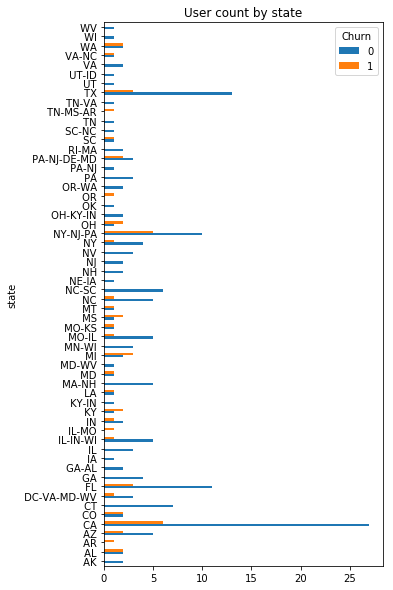

In [49]:
ax = (location_chunc_count
      .groupby(['Churn','state'], as_index=False)['user_count']
      .sum()
      .pivot(index='state', columns='Churn', values='user_count')
      .plot.barh(rot=0,title = 'User count by state', figsize=(5,10))
      
     )

- It is difficult to validate the state, it will be necesary to scale the data group by Churn

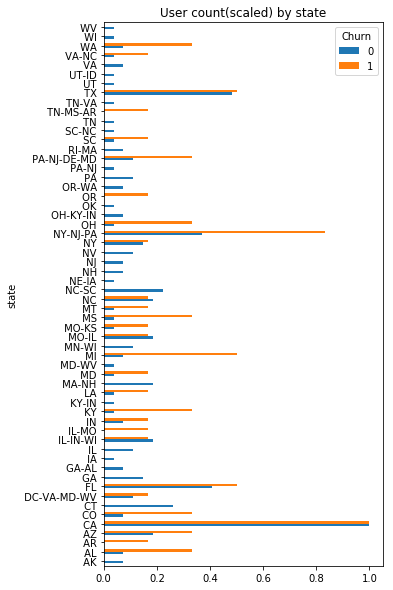

In [50]:
scale_data_by_Churn(location_chunc_count,'state').plot.barh(rot=0,title = 'User count(scaled) by state', figsize=(5,10))

#### page

In [51]:
#get users by Location
page_count = spark.sql('''
        SELECT Churn,page,COUNT(*) AS page_count
        FROM Sparkify_churn_view
        GROUP BY Churn,page
        order by Churn, page_count desc
''').toPandas()
page_count_scaled = scale_data_by_Churn(page_count,'page','page_count')
page_count_scaled

Churn,0,1
page,,
About,0.002290,0.001292
Add Friend,0.018992,0.017232
Add to Playlist,0.028626,0.028281
Cancel,0.000000,0.001182
Cancellation Confirmation,0.000000,0.001182
Downgrade,0.008961,0.009015
Error,0.001148,0.000632
Help,0.006338,0.006321
Home,0.043867,0.045706


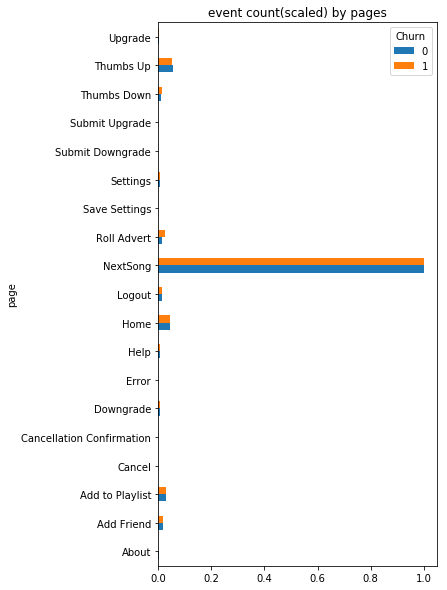

In [52]:
page_count_scaled.plot.barh(rot=0,title = 'event count(scaled) by pages', figsize=(5,10))

In [53]:
page_count_pivot = df_churn.groupBy(['Churn','UserId','SessionId']).pivot('page').count().na.fill(0).toPandas()

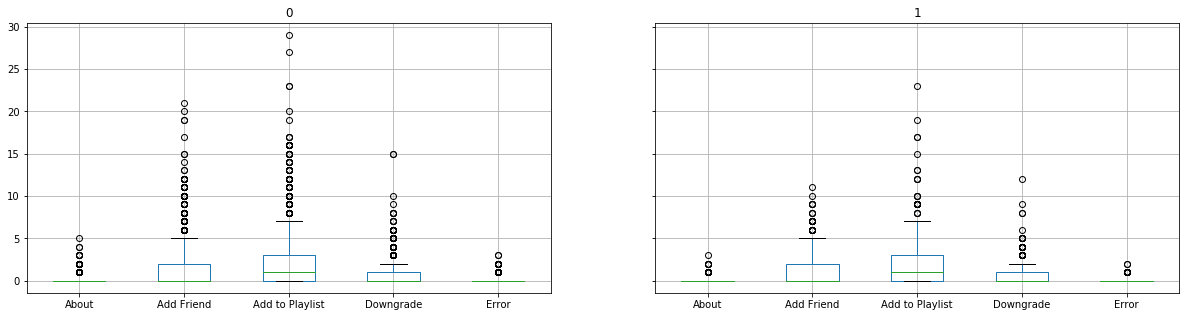

In [54]:
page_review_list = ['About','Add Friend','Add to Playlist','Downgrade','Error']
boxplot = page_count_pivot.groupby('Churn',as_index=False).boxplot(column=page_review_list, figsize=(20,5))

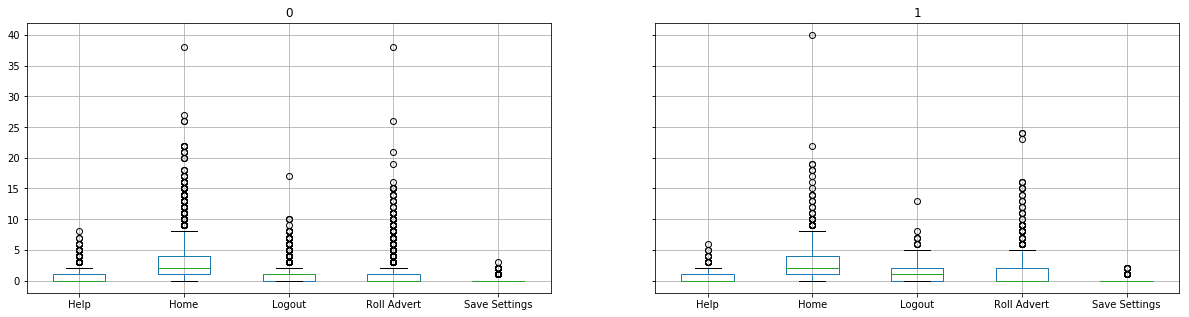

In [55]:
page_review_list = ['Help','Home','Logout','Roll Advert','Save Settings']
boxplot = page_count_pivot.groupby('Churn',as_index=False).boxplot(column=page_review_list, figsize=(20,5))

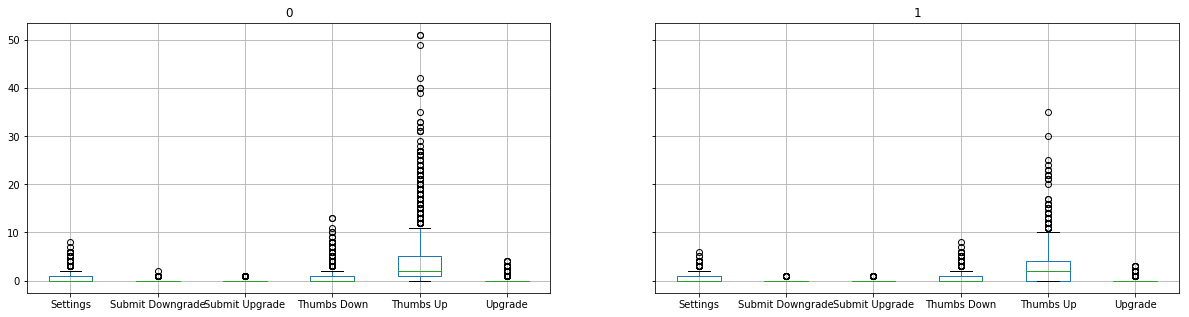

In [56]:
page_review_list = ['Settings', 'Submit Downgrade','Submit Upgrade','Thumbs Down','Thumbs Up','Upgrade']
boxplot = page_count_pivot.groupby('Churn',as_index=False).boxplot(column=page_review_list, figsize=(20,5))

In [57]:
validate_two_sided_hypotesis ('About',[0.002290,0.001292],[1,1])
validate_two_sided_hypotesis ('Thumbs Down',[0.010693,0.013385],[1,1])
validate_two_sided_hypotesis ('Thumbs Down',[0.055771,0.050845],[1,1])
validate_two_sided_hypotesis ('Roll Advert',[0.015471,0.026330],[1,1])

z_stat: 0.017, p_value: 0.987
Fail to reject the null hypothesis - proportions from the two populations based on 'About' are the same 
z_stat: -0.017, p_value: 0.986
Fail to reject the null hypothesis - proportions from the two populations based on 'Thumbs Down' are the same 
z_stat: 0.016, p_value: 0.988
Fail to reject the null hypothesis - proportions from the two populations based on 'Thumbs Down' are the same 
z_stat: -0.054, p_value: 0.957
Fail to reject the null hypothesis - proportions from the two populations based on 'Roll Advert' are the same 


- Checking the pages with more difference, that doesn't have a significant difference yet. However, they will be useful to add to our model.

#### sessionId

In [58]:
# session information 
session_count_Churn = spark.sql("""
    SELECT 
        Churn,
        UserId, 
        SessionId, 
        COUNT(song) songs_count,
        cast((max(ts) - min(ts))/3600000.0 as Integer) session_duration_hours
        FROM Sparkify_churn_view
    GROUP BY Churn,UserId,SessionId
""").toPandas()

In [59]:
session_count_Churn.groupby('Churn')["session_duration_hours","songs_count"].describe()

session_duration_hours                                                \
                       count      mean       std  min  25%  50%  75%   max   
Churn                                                                        
0                     2639.0  4.586965  6.523236  0.0  0.0  2.0  6.0  74.0   
1                      537.0  4.243948  6.252618  0.0  0.0  2.0  5.0  55.0   

      songs_count                                                       
            count       mean        std  min   25%   50%   75%     max  
Churn                                                                   
0          2639.0  72.646457  93.677255  0.0  15.0  40.0  91.5  1093.0  
1           537.0  67.772812  88.168113  0.0  13.0  38.0  86.0   708.0

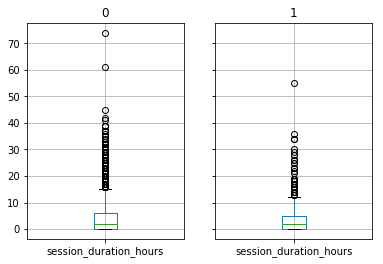

In [60]:
boxplot = session_count_Churn.groupby('Churn',as_index=False)["session_duration_hours"].boxplot(column=['session_duration_hours'])

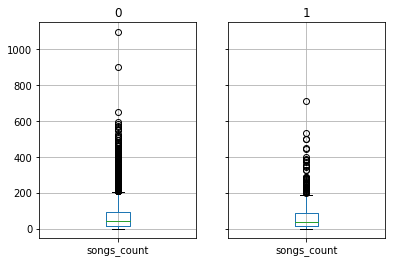

In [61]:
boxplot = session_count_Churn.groupby('Churn',as_index=False)["songs_count"].boxplot(column=['songs_count'])

- On average  the persons that have Churned, they spend a little bit less time that the ones that doesn't; 

#### status

In [62]:
# describe status by Session
status_count_churn = df_churn.groupBy(['Churn','UserId','SessionId']).pivot('status').count().na.fill(0).toPandas()
status_count_churn.groupby('Churn')["200","307","404"].describe()

200                                                            307  \
        count       mean         std  min   25%   50%    75%     max   count   
Churn                                                                          
0      2639.0  80.932550  102.051957  1.0  17.0  45.0  103.0  1183.0  2639.0   
1       537.0  76.605214   96.356346  1.0  16.0  44.0   98.0   791.0   537.0   

                ...                  404                                     \
           mean ...    75%   max   count      mean       std  min  25%  50%   
Churn           ...                                                           
0      7.384994 ...   10.0  99.0  2639.0  0.083365  0.310090  0.0  0.0  0.0   
1      6.880819 ...    9.0  64.0   537.0  0.059590  0.252203  0.0  0.0  0.0   

                 
       75%  max  
Churn            
0      0.0  3.0  
1      0.0  2.0  

[2 rows x 24 columns]

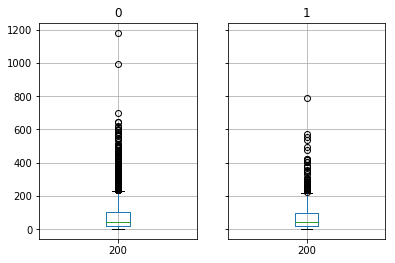

In [63]:
boxplot = status_count_churn.groupby('Churn',as_index=False)["200"].boxplot(column=['200'])

- the application has similar behavior for the states.
#### time

In [64]:
hour_data_Churn =  spark.sql("""
    SELECT  
        Churn,
        dayOfWeek(from_unixtime( ts/1000.00)) dayofweek,
        hour(from_unixtime( ts/1000.00)) hour,
        count(*) count
    FROM Sparkify_churn_view
    group by 
        Churn,
        dayOfWeek(from_unixtime( ts/1000.00)) ,
        dayofmonth(from_unixtime( ts/1000.00)) ,
        hour(from_unixtime( ts/1000.00)) 
        
    
""").toPandas()

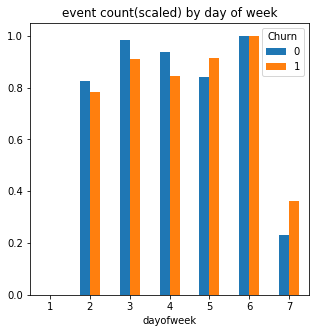

In [65]:
hour_data_scaled = scale_data_by_Churn(hour_data_Churn,'dayofweek','count')
hour_data_scaled.plot.bar(rot=0,title = 'event count(scaled) by day of week', figsize=(5,5))

- the biggest difference is at saturday
#### User agent

In [66]:
#User Agent
df_os_family = (df_churn
                .withColumn('OS_family',udf_os_family(df.userAgent))
                .withColumn('device_family',udf_device_family(df.userAgent))
                .withColumn('browser_family',udf_browser_family(df.userAgent))
               )
#each user is connection only by a common userAgent
df_pivot_device = df_os_family.groupBy(["Churn","userId","device_family"]).agg(F.lit(1)).na.fill(0).toPandas().drop(columns=['userId'])
df_pivot_browser = df_os_family.groupBy(["Churn","userId","browser_family"]).agg(F.lit(1)).na.fill(0).toPandas().drop(columns=['userId'])
df_pivot_OS = df_os_family.groupBy(["Churn","userId","OS_family"]).agg(F.lit(1)).na.fill(0).toPandas().drop(columns=['userId'])

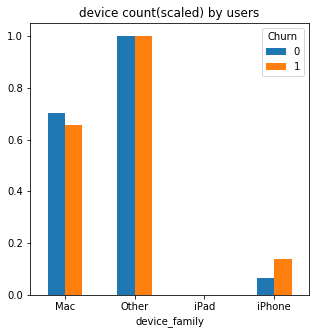

In [67]:
df_pivot_device_scaled = scale_data_by_Churn(df_pivot_device,'device_family','1')
df_pivot_device_scaled.plot.bar(rot=0,title = 'device count(scaled) by users', figsize=(5,5))

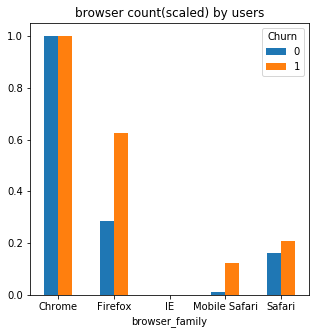

In [68]:
df_pivot_browser_scaled = scale_data_by_Churn(df_pivot_browser,'browser_family','1')
df_pivot_browser_scaled.plot.bar(rot=0,title = 'browser count(scaled) by users', figsize=(5,5))

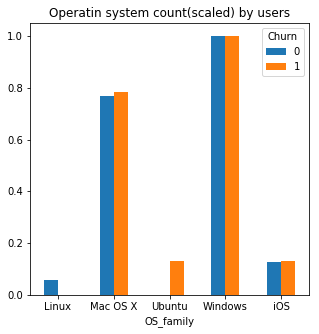

In [69]:
df_pivot_OS_scaled = scale_data_by_Churn(df_pivot_OS,'OS_family','1')
df_pivot_OS_scaled.plot.bar(rot=0,title = 'Operatin system count(scaled) by users', figsize=(5,5))

- There are more difference by OS and browser

# Feature Engineering
Once you've familiarized yourself with the data, build out the features you find promising to train your model on. To work with the full dataset, you can follow the following steps.
- Write a script to extract the necessary features from the smaller subset of data
- Ensure that your script is scalable, using the best practices discussed in Lesson 3
- Try your script on the full data set, debugging your script if necessary

If you are working in the classroom workspace, you can just extract features based on the small subset of data contained here. Be sure to transfer over this work to the larger dataset when you work on your Spark cluster.

### Features to extract based on the data exploration and Churn definition
Th data will be present by userId
1. Categorical Features (need label encoding)
 - gender
 - pages (remove `Cancellation Confirmation` and `Cancel`)
 - Browser (extracted from `userAgent`)
 - OS (extracted from `userAgent`)
2. Numerical Features (need to be scaled)
 - mean of songs in a session
 - mean of session duration  (in hours)
 - mean of events (registers) in a session
 - days of use

In [70]:
def df_rename_columns (df, column_name_prefix,not_add_prefix_columns=['userId']):
    """
    rename columns in a spark dataframe
    
    :param df: spark dataframe - dataframe to work on 
    :param column_name_prefix: string - string to add as a prefix for each column
    :param not_add_prefix_columns: list - list of columns to not add the prefix
    :return: spark dataframe - dataframe with the columns modified
    """
    
    df_column_names = df.schema.names
    column_names = [column for column in df_column_names if column not in not_add_prefix_columns]
    df = reduce(lambda data, idx: data.withColumnRenamed(column_names[idx], 
                                                               column_name_prefix + '_' + column_names[idx]
                                                               .lower()
                                                               .replace(' ','_')), 
                      range(len(column_names)), df)
    return df

In [71]:
def df_pivot_normalize (df, 
                        pivot_column_name , 
                        columns_to_drop =['sessionId'], 
                        main_group_by = ['userId'], 
                        intermediate_group_by = ['userId','sessionId'] ):
    """
    perform pivot to generate label encoding data from categorical column 
    and normilize the cout related to the other categorical variables
    
    :param df: spark dataframe - dataframe to work on 
    :param pivot_column_name: string - column to perform pivot (column with categorical data)
    :param columns_to_drop: list - column to drop, the reason is because normally the session will not be necessary anymore
    :param main_group_by: list - list of columns to broup by and return the data
    :param intermediate_group_by: list - list of columns tro group by 
    :return: spark dataframe - dataframe with the new columns
    """
    df_pivot = df.groupBy(intermediate_group_by).pivot(pivot_column_name).count().na.fill(0)

    # get column names that need to be normalized
    cols = [col for col in df_pivot.columns if col not in intermediate_group_by]

    # sum the columns by row
    rowsum = sum([df_pivot[x] for x in cols])

    # select userId and SessionId and normalize other columns by rowsum
    df_pivot = df_pivot.select(*(intermediate_group_by), 
                               *((df_pivot[x] / rowsum)
                                 .alias(pivot_column_name+'_'+x.lower().replace(' ','_')) for x in cols))

    #get colum names previous to group by
    Expected_column_names = df_pivot.schema.names 
    
    #group by according to 
    df_pivot  = df_pivot.groupBy(main_group_by).avg().na.fill(0)

    to_replace_column_names = df_pivot.schema.names

    #replace names as previous to the groupBy
    df_pivot = reduce(lambda data, idx: data.withColumnRenamed(to_replace_column_names[idx], Expected_column_names[idx]), 
                      range(len(to_replace_column_names)), df_pivot)

    # remove sessionId column
    df_pivot = df_pivot.drop(*columns_to_drop)
    
    return df_pivot

In [72]:
def df_scale (df, not_scale_columns =['userId']):
    """
    perform scale on each column of the dataframe
    
    :param df: spark dataframe - dataframe to work on 
    :param not_scale_columns: list - list of column names that do not need reescaling
    """
    unlist = udf(lambda x: round(float(list(x)[0]),5), DoubleType())
    
    df_column_names = df.schema.names 
    columns = [column for column in df_column_names if column not in not_scale_columns]

    for column in columns:
        column_scaled = column+"_scaled"
        if column_scaled not in columns:
            # VectorAssembler Transformation - Converting column to vector type
            column_vector = column+"_vector"
            assembler = VectorAssembler(inputCols=[column],outputCol=column_vector)

            # get scaler (MinMaxScaler) Transformation
            scaler = MinMaxScaler(inputCol=column_vector, outputCol=column_scaled)

            # Pipeline of VectorAssembler and MinMaxScaler
            pipeline = Pipeline(stages=[assembler, scaler])

            # fitting pipeline on dataframe
            df = pipeline.fit(df).transform(df).withColumn(column_scaled, unlist(column_scaled)).drop(column_vector)

            df = df.drop(column)
    return df
    


In [73]:
df_user =  spark.sql("""
    SELECT  userId, 
            max(Churn) Churn, 
            max(case when level = 'paid' then 1 else 0 end ) level,
            max(case when gender = 'M' then 1 else 0 end ) gender,
            avg(length) lenght_avg
        FROM Sparkify_churn_view
        group by userId
    
""")
df_user = df_scale(df_user,['userId','Churn','gender','level'])
df_user.limit(5).toPandas()

,userId,Churn,level,gender,lenght_avg_scaled
0,100010,0,0,0,0.42822
1,200002,0,1,1,0.41638
2,125,1,0,1,0.84434
3,124,0,1,0,0.53990
4,51,1,1,1,0.53295


In [74]:
df_day_week =  spark.sql("""
    SELECT  
            userId,
            sessionId, 
            dayOfWeek(from_unixtime( ts/1000.00)) day_of_week
        FROM Sparkify_view   
""")
df_pivot_day_week = df_pivot_normalize(df = df_day_week, pivot_column_name = "day_of_week")
df_pivot_day_week = df_scale(df_pivot_day_week)
df_pivot_day_week.limit(5).toPandas()

,userId,day_of_week_1_scaled,day_of_week_2_scaled,day_of_week_3_scaled,day_of_week_4_scaled,day_of_week_5_scaled,day_of_week_6_scaled,day_of_week_7_scaled
0,100010,0.00000,0.42857,0.14286,0.14286,0.00000,0.14286,0.14286
1,200002,0.00000,0.29450,0.37217,0.00000,0.33333,0.00000,0.00000
2,125,0.00000,0.00000,0.00000,0.00000,0.00000,1.00000,0.00000
3,51,0.06837,0.29770,0.19862,0.11495,0.19797,0.14206,0.01452
4,124,0.06529,0.20814,0.13840,0.20518,0.09048,0.26804,0.05711


In [75]:
udf_os_family = udf(lambda x: parse(x).os.family, StringType())
udf_browser_family = udf(lambda x: parse(x).browser.family, StringType())

df_os_family = (df
                .withColumn('OS_family',udf_os_family(df.userAgent))
                .withColumn('browser_family',udf_browser_family(df.userAgent))
               )
#each user is connection only by a common userAgent
df_pivot_browser = df_rename_columns(df_os_family.groupBy("userId").pivot("browser_family").agg(F.lit(1)).na.fill(0),'browser')
df_pivot_OS = df_rename_columns(df_os_family.groupBy("userId").pivot("OS_family").agg(F.lit(1)).na.fill(0),'OS')

In [76]:
df_pivot_browser.limit(5).toPandas()

,userId,browser_chrome,browser_firefox,browser_ie,browser_mobile_safari,browser_safari
0,100010,0,0,0,1,0
1,200002,0,0,0,1,0
2,125,1,0,0,0,0
3,51,1,0,0,0,0
4,124,1,0,0,0,0


In [77]:
df_pivot_OS.limit(5).toPandas()

,userId,OS_linux,OS_mac_os_x,OS_ubuntu,OS_windows,OS_ios
0,100010,0,0,0,0,1
1,200002,0,0,0,0,1
2,125,0,1,0,0,0
3,51,0,0,0,1,0
4,124,0,1,0,0,0


In [78]:
df_pivot_page = df_pivot_normalize(df = df, 
                                   pivot_column_name = "page",
                                   columns_to_drop=['sessionId','page_cancellation_confirmation','page_cancel'],
                                  )
df_pivot_page = df_scale(df_pivot_page)
df_pivot_page.limit(5).toPandas()

,userId,page_about_scaled,page_add_friend_scaled,page_add_to_playlist_scaled,page_downgrade_scaled,page_error_scaled,page_help_scaled,page_home_scaled,page_logout_scaled,page_nextsong_scaled,page_roll_advert_scaled,page_save_settings_scaled,page_settings_scaled,page_submit_downgrade_scaled,page_submit_upgrade_scaled,page_thumbs_down_scaled,page_thumbs_up_scaled,page_upgrade_scaled
0,100010,0.05102,0.04360,0.17386,0.00000,0.00000,0.02191,0.10564,0.18763,0.50549,0.60525,0.00000,0.00000,0.0,0.00000,0.19745,0.28852,0.16029
1,200002,0.31370,0.06209,0.40326,0.08663,0.00000,0.01094,0.10555,0.07293,0.55884,0.24134,0.00000,0.04649,0.0,0.18421,0.12366,0.42187,0.12099
2,125,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.49599,0.48701,0.00000,0.00000,0.0,0.00000,0.00000,0.00000,0.00000
3,51,0.01589,0.03723,0.25390,0.12677,0.03259,0.04170,0.07542,0.05055,0.73179,0.00000,0.01137,0.02540,0.0,0.00000,0.32047,0.26601,0.00000
4,124,0.03864,0.06083,0.28420,0.13172,0.08078,0.02283,0.23634,0.13184,0.61700,0.00150,0.07655,0.01608,0.0,0.00000,0.11434,0.26407,0.00000


In [79]:
df_session =  spark.sql("""
    WITH session as ( 
        SELECT  userId, 
                sessionId,
                count(song) songs,
                (max(ts) - min(ts))/360000.0 session_duration,
                count(*) event_count
            FROM Sparkify_churn_view
            GROUP BY userId,sessionId
        )
    SELECT 
        userId,
        avg(songs) songs_by_session,
        avg(session_duration) session_duration,
        avg(event_count) event_count_by_session,
        count(*) total_sessions
    FROM session
    GROUP BY
        userId

""")
df_session = df_scale(df_session)
df_session.limit(5).toPandas()


,userId,songs_by_session_scaled,session_duration_scaled,event_count_by_session_scaled,total_sessions_scaled
0,100010,0.12792,0.12574,0.14725,0.05660
1,200002,0.21680,0.22116,0.22196,0.04717
2,125,0.01763,0.01924,0.01520,0.00000
3,124,0.48527,0.48768,0.48764,0.26415
4,51,0.73361,0.73779,0.73095,0.08491


In [80]:
df_final = (df_user.join(df_pivot_day_week, on=['userId'], how='inner')
            .join(df_session, on=['userId'], how='inner')
            .join(df_pivot_browser, on=['userId'], how='inner')
            .join(df_pivot_OS, on=['userId'], how='inner')
            .join(df_pivot_page, on=['userId'], how='inner')
           )

In [81]:
df_final.printSchema()

root
 |-- userId: string (nullable = true)
 |-- Churn: integer (nullable = true)
 |-- level: integer (nullable = true)
 |-- gender: integer (nullable = true)
 |-- lenght_avg_scaled: double (nullable = true)
 |-- day_of_week_1_scaled: double (nullable = true)
 |-- day_of_week_2_scaled: double (nullable = true)
 |-- day_of_week_3_scaled: double (nullable = true)
 |-- day_of_week_4_scaled: double (nullable = true)
 |-- day_of_week_5_scaled: double (nullable = true)
 |-- day_of_week_6_scaled: double (nullable = true)
 |-- day_of_week_7_scaled: double (nullable = true)
 |-- songs_by_session_scaled: double (nullable = true)
 |-- session_duration_scaled: double (nullable = true)
 |-- event_count_by_session_scaled: double (nullable = true)
 |-- total_sessions_scaled: double (nullable = true)
 |-- browser_chrome: integer (nullable = true)
 |-- browser_firefox: integer (nullable = true)
 |-- browser_ie: integer (nullable = true)
 |-- browser_mobile_safari: integer (nullable = true)
 |-- browser_

# Modeling
Split the full dataset into train, test, and validation sets. Test out several of the machine learning methods you learned. Evaluate the accuracy of the various models, tuning parameters as necessary. Determine your winning model based on test accuracy and report results on the validation set. Since the churned users are a fairly small subset, I suggest using F1 score as the metric to optimize.

In [82]:
#creating features column
assembler = VectorAssembler(
    inputCols=[column for column in df_final.schema.names if column not in ['userId','Churn']],
    outputCol="features")
df_output = assembler.transform(df_final)

In [83]:
# spliting 70%  for training and 30% testing set
df_train, df_test = df_output.randomSplit([0.7,0.3])

In [84]:
# Generate models
dtc=DecisionTreeClassifier(labelCol='Churn',featuresCol='features',seed=8)
gbt=GBTClassifier(labelCol='Churn',featuresCol='features',seed=8)
rfc=RandomForestClassifier(labelCol='Churn',featuresCol='features',numTrees=300)
svm = LinearSVC(labelCol='Churn',featuresCol='features')

In [86]:
results ={}
for classifier in [dtc, gbt, rfc, svm]:
    model_results = {}
    # get the classifier name
    classifier_name = classifier.__class__.__name__
    
    # train the dataset
    print(f'{classifier_name}: ')
    print(f'    Training data...')
    start_time = time.time() 
    model = classifier.fit(df_train)
    model_results['training_time'] = round(time.time() - start_time,6)
    print('        training time: '+ str(model_results['training_time']))
    
    # predict data
    print(f'    predict...')
    start_time = time.time() 
    pred_test = model.transform(df_test)
    model_results['prediction_time'] = round(time.time()-start_time,6)
    print('        prediction time: '+ str(model_results['prediction_time']))
    
    #metrics
    print(f'    evaluation of testing data')    
    start_time = time.time() 
    metric_accuracy = MulticlassClassificationEvaluator(labelCol="Churn",predictionCol="prediction",metricName="accuracy")
    metric_f1 = MulticlassClassificationEvaluator(labelCol="Churn",predictionCol="prediction",metricName="f1")
    
    model_results['accuracy_score'] = metric_accuracy.evaluate(pred_test)
    model_results['f1_score'] = metric_f1.evaluate(pred_test)
    
    model_results['evaluation_time'] = round(time.time()-start_time,6)
    print('        evaluation time: '+ str(model_results['evaluation_time']))
    print('')
    print('        accuracy-score: '+str(model_results["accuracy_score"])+' F1-score: '+str(model_results["f1_score"]))
    results[classifier] = model_results
    

    

DecisionTreeClassifier: 
    Training data
        training time: 482.285003
    predict
        prediction time: 0.132027
    evaluation of testing data
        evaluation time: 456.859129

        accuracy-score: 0.6617647058823529 F1-score: 0.6460413354531002
GBTClassifier: 
    Training data
        training time: 741.4513
    predict
        prediction time: 0.208214
    evaluation of testing data
        evaluation time: 431.491969

        accuracy-score: 0.6323529411764706 F1-score: 0.6272311167076413
RandomForestClassifier: 
    Training data
        training time: 528.969728
    predict
        prediction time: 0.171576
    evaluation of testing data
        evaluation time: 435.798042

        accuracy-score: 0.7794117647058824 F1-score: 0.7182402372713792
LinearSVC: 
    Training data
        training time: 1895.78658
    predict
        prediction time: 0.0881
    evaluation of testing data
        evaluation time: 429.042291

        accuracy-score: 0.8382352941176471 F1-

In [89]:
df_results.columns =['DecisionTreeClassifier','GBTClassifier','RandomForestClassifier','LinearSVC']

In [92]:
df_results = pd.DataFrame(results)
df_results.to_csv('results.csv')
df_results.head()

,DecisionTreeClassifier_fdf591f7a55f,GBTClassifier_99295674a3d2,RandomForestClassifier_171afa36ff18,LinearSVC_433c7818f774
accuracy_score,0.661765,0.632353,0.779412,0.838235
evaluation_time,456.859129,431.491969,435.798042,429.042291
f1_score,0.646041,0.627231,0.718240,0.806144
prediction_time,0.132027,0.208214,0.171576,0.088100
training_time,482.285003,741.451300,528.969728,1895.786580


# Final Steps
Clean up your code, adding comments and renaming variables to make the code easier to read and maintain. Refer to the Spark Project Overview page and Data Scientist Capstone Project Rubric to make sure you are including all components of the capstone project and meet all expectations. Remember, this includes thorough documentation in a README file in a Github repository, as well as a web app or blog post.